In this network we train classifier attached to VGG16 (imagenet weights), preprocessed dataset

### Environment

In [11]:
# connect to google drive
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH, force_remount = True)
%cd /content/gdrive/MyDrive/ProgettoAI/SarasRoom

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/gdrive/MyDrive/ProgettoAI/SarasRoom'
/content


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import random
from PIL import Image
import warnings
import cv2
from skimage.color import rgb2gray
from skimage import filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.9.2


In [13]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

### Dataset

In [ ]:
data_dir = '/content/gdrive/MyDrive/ProgettoAI/Processed_dataset'
#data_dir = '/kaggle/input/corino-preprocessed/'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [14]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

h = 256
w = 256
#batch_size = 8

#imageDataGenerator
train_set = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory = training_dir,
                                                     target_size = (h, w),
                                                     color_mode = 'rgb',
                                                     classes = None,
                                                     class_mode = 'categorical',
                                                     batch_size = 32, 
                                                     shuffle = True,
                                                     seed = seed)

validation_set = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory = validation_dir,
                                                     target_size = (h, w),
                                                     color_mode = 'rgb',
                                                     classes = None,
                                                     class_mode = 'categorical',
                                                     batch_size = 32, 
                                                     shuffle = False,
                                                     seed = seed)

test_set = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory = test_dir,
                                                     target_size = (h, w),
                                                     color_mode = 'rgb',
                                                     classes = None,
                                                     class_mode = 'categorical',
                                                     batch_size = 32, 
                                                     shuffle = False,
                                                     seed = seed)

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


In [15]:
input_shape = (256, 256, 3)

 ### Transfer Learning
 

In [16]:
#Download net
supernet =tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(input_shape)
)

#supernet.summary()
#tfk.utils.plot_model(supernet)

In [ ]:
#Classifier
supernet.trainable = False

inputs = tfk.Input(shape=input_shape)
x = supernet(inputs) #one layer is supernet
x = tfkl.GlobalAveragePooling2D(name = 'gap')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    128, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    3, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [ ]:
earlystopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)

# Learning Rate callback
learningrate = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.1, min_lr=1e-8, verbose = 1)

callbacks_list = [earlystopping, learningrate]

In [ ]:
# Train the model
history = tl_model.fit(
    x = train_set,
    epochs = 200,
    validation_data = validation_set,
    callbacks = callbacks_list
).history

Epoch 1/200
339/339 [==============================] - 73s 216ms/step - loss: 0.1426 - accuracy: 0.9442 - val_loss: 0.1442 - val_accuracy: 0.9433
Epoch 3/200
339/339 [==============================] - 73s 214ms/step - loss: 0.1429 - accuracy: 0.9442 - val_loss: 0.1421 - val_accuracy: 0.9446
Epoch 4/200
339/339 [==============================] - 74s 217ms/step - loss: 0.1343 - accuracy: 0.9486 - val_loss: 0.1421 - val_accuracy: 0.9459
Epoch 5/200
339/339 [==============================] - 73s 215ms/step - loss: 0.1442 - accuracy: 0.9434 - val_loss: 0.1418 - val_accuracy: 0.9463
Epoch 6/200
339/339 [==============================] - 73s 215ms/step - loss: 0.1348 - accuracy: 0.9502 - val_loss: 0.1430 - val_accuracy: 0.9446
Epoch 7/200
339/339 [==============================] - 73s 217ms/step - loss: 0.1338 - accuracy: 0.9473 - val_loss: 0.1432 - val_accuracy: 0.9446
Epoch 8/200
339/339 [==============================] - 73s 216ms/step - loss: 0.1369 - accuracy: 0.9479 - val_loss: 0.1449 -

### Results

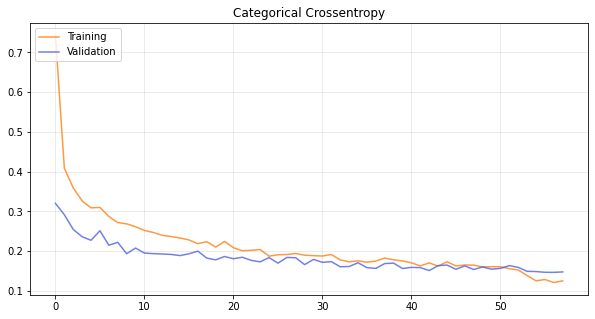

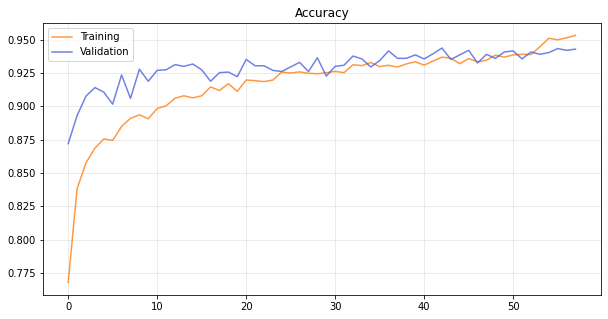

In [ ]:
# Plot the training

# loss
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)


In [ ]:
tl_model.save('/kaggle/working')

2023-01-28 22:30:08.139298: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
[test_loss, test_accuracy] = tl_model.evaluate(test_set)

73/73 [==============================] - 24s 333ms/step - loss: 0.1764 - accuracy: 0.9311


In [ ]:
#cf on validation for comparisons
val_predictions = tl_model.predict(validation_set)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions))

In [ ]:
y_val = validation_set.labels

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1420
           1       0.96      0.96      0.96       635
           2       0.94      0.75      0.84       272

    accuracy                           0.95      2327
   macro avg       0.95      0.90      0.92      2327
weighted avg       0.95      0.95      0.94      2327



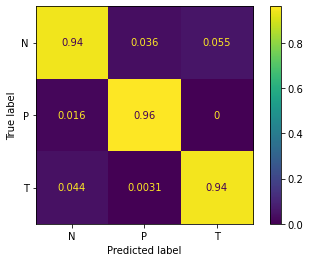

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

In [ ]:
!zip -r densenet_preprocessing.zip /kaggle/working

In [ ]:
!zip -r VGG16_preprocess.zip /kaggle/working
from IPython.display import FileLink 
FileLink(r'VGG16_preprocess.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/assets/ (stored 0%)
  adding: kaggle/working/saved_model.pb (deflated 90%)
  adding: kaggle/working/variables/ (stored 0%)
  adding: kaggle/working/variables/variables.index (deflated 65%)
  adding: kaggle/working/variables/variables.data-00000-of-00001 (deflated 7%)


/kaggle/working/VGG16_preprocess.zip